<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [4]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 787.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [215]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum


In [6]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: []
Userai: cpu


Collegamento al drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [8]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [9]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [216]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
DURATION = 5.0       # lunghezza standard (secondi)

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9

decido di non rimuovere il silenzio

In [56]:
def load_audio_file(file_path, sr=44100, duration=5.0):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    y = librosa.util.normalize(y)           # normalizzazione RMS
    if len(y) < int(sr * duration):
        padding = int(sr * duration) - len(y)
        y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

In [57]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


In [58]:
X_audio = np.array(X_audio)
y_labels = np.array(y_labels)

print("Shape X:", X_audio.shape)
print("Shape y:", y_labels.shape)

Shape X: (400, 220500)
Shape y: (400,)


In [59]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.3, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 280, Val: 60, Test: 60


## NAA

tolgo il silenzio? su esc10 si su esc50 no ?
metto noise injection?
noise = np.random.normal(0, 0.005, y.shape)
  y_noisy = y + noise
  augmented.append(y_noisy)

In [60]:
def naa(y, sr):
  augmented = []
  augmented.append(y)
  #PPS
  augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2))
  #NPS
  augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2))
  #Slow Time Stretching
  augmented.append(librosa.effects.time_stretch(y, rate=0.7))
  #Fast Time Streatching
  augmented.append(librosa.effects.time_stretch(y, rate=1.2))
  return augmented

In [61]:
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))


NAA: 100%|██████████| 280/280 [02:02<00:00,  2.28it/s]


## Converti in log-Mel

In [62]:
def preprocess_audio(y, sr=44100, n_mels=64, n_fft=1024, hop_length=512):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


In [63]:
def batch_logmel(X, sr=44100):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        mel_list.append(mel)
    return mel_list


In [64]:
X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

Log-Mel: 100%|██████████| 60/60 [00:00<00:00, 101.80it/s]


In [65]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 1400
Val set: 60
Test set: 60
Shape primo sample train: (64, 431)


visualizzo logmel spect

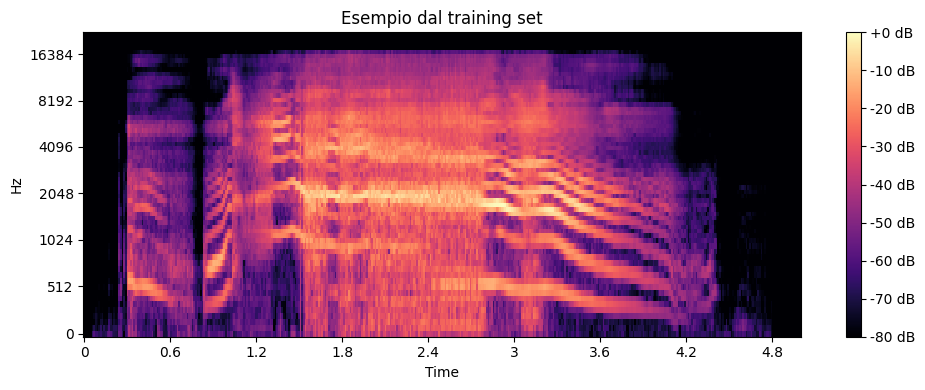

Class:  3


In [66]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
show_mel(X_train_mel[0], title="Esempio dal training set")
print("Class: ", y_train_aug[0])


In [67]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding

In [68]:
max_len = max([mel.shape[1] for mel in X_train_mel])
def pad_mel(mel, max_len):
    if mel.shape[1] < max_len:
        pad_width = max_len - mel.shape[1]
        return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
    else:
        return mel[:, :max_len]
X_train_mel = [pad_mel(mel, max_len) for mel in X_train_mel]
X_val_mel = [pad_mel(mel, max_len) for mel in X_val_mel]
X_test_mel = [pad_mel(mel, max_len) for mel in X_test_mel]


## DATA AUG TAA

In [69]:
taa_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    brightness_range=[0.5, 1.5],
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [70]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

y_train_np = np.array(y_train_aug)  # Etichette corrispondenti

Normalizzazione

In [71]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

Converto in tensori

In [72]:
X_train = torch.from_numpy(X_train_mel_np).float()
y_train = torch.from_numpy(y_train_np).float()
X_val = torch.from_numpy(X_val_mel_np).float()
y_val = torch.from_numpy(np.array(y_val)).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_test = torch.from_numpy(np.array(y_test)).float()

In [75]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([1400, 64, 616, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


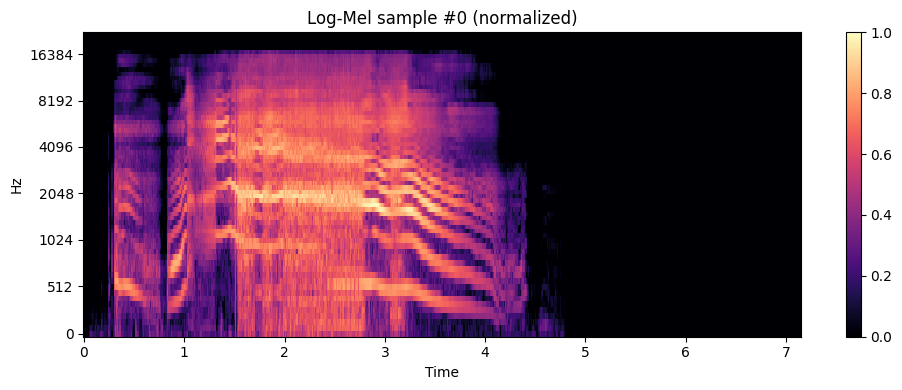

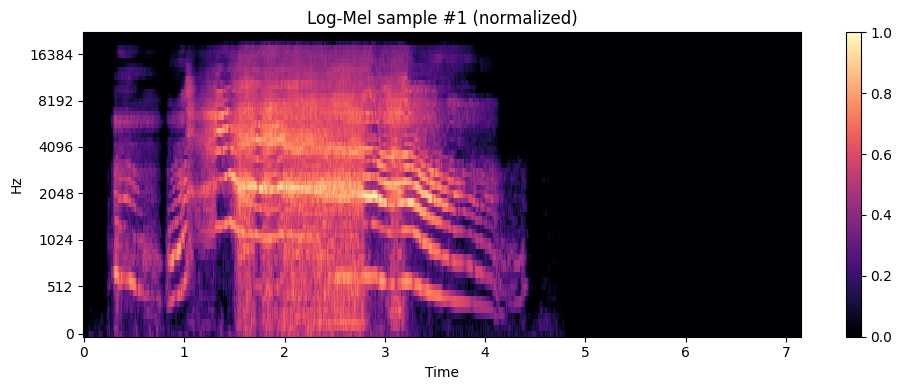

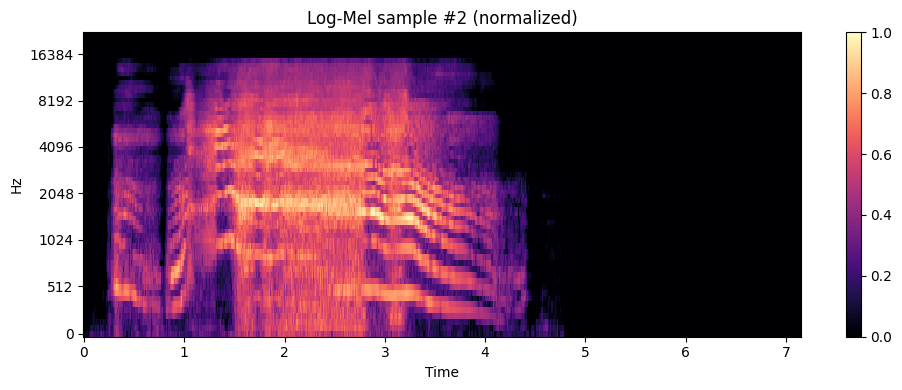

In [76]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()

for i in range(3):
    show_mel_sample(i)

In [77]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([1400])
Etichette uniche: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Esempio 0: label = 3.0
Esempio 1: label = 3.0
Esempio 2: label = 3.0


# Data Loader

In [133]:
class AudioDataset(Dataset):

  def __init__(self, data, labels):
    self.data = data.clone().detach().float()
    self.labels = labels.clone().detach().long()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]


In [134]:
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Spike Encoding


## Rate Encoding

Si tratta di un metodo classico e semplice: l'informazione viene codificata nella frequenza di sparo (numero di spike per unità di tempo). Stimolo più alto → frequenza più alta. Non è importante l'esatta tempistica degli spike, ma solo il loro numero.

Each normalized input feature $X_{i,j}$ is used as the probability a spike occurs at any given time step.

Bernoulli trial: $R_{i,j} \sim B(n, p)$

The probability a spike occurs is:
$P(R_{i,j} = 1) = X_{i,j} = 1 - P(R_{i,j} = 0)$

We show now the distribution of values of a single mel plot

Min: 0.0000
Max: 1.0000
Mean: 0.2424
Std: 0.2764


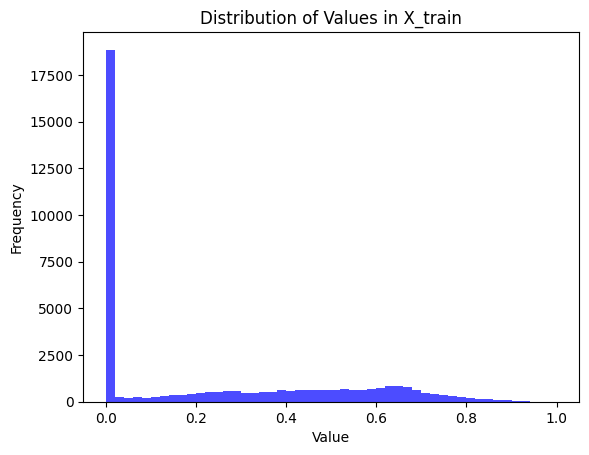

In [89]:
# simulation time steps
X_train_rate_batch = torch.squeeze(X_train)[0:1]

# Flatten to 1D for easy stats and histogram
tensor_flat = X_train_rate_batch.flatten()

# Print basic stats
print(f"Min: {tensor_flat.min().item():.4f}")
print(f"Max: {tensor_flat.max().item():.4f}")
print(f"Mean: {tensor_flat.mean().item():.4f}")
print(f"Std: {tensor_flat.std().item():.4f}")

# Plot histogram
plt.hist(tensor_flat.cpu().numpy(), bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Values in X_train")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

Now we generate the spike ratings over a single mel plot

In [32]:
simulation_steps = 50
rate_spike_train = spikegen.rate(data=X_train_rate_batch, num_steps=simulation_steps, gain=1)
print(rate_spike_train.shape)

torch.Size([50, 1, 64, 616])


**simulation_steps** is needed because data is converted into spikes that evolve over 50 time steps. Each step simulates activity in an SNN at that particular moment in time

Now we visualize the spike_train

torch.Size([50, 39424])


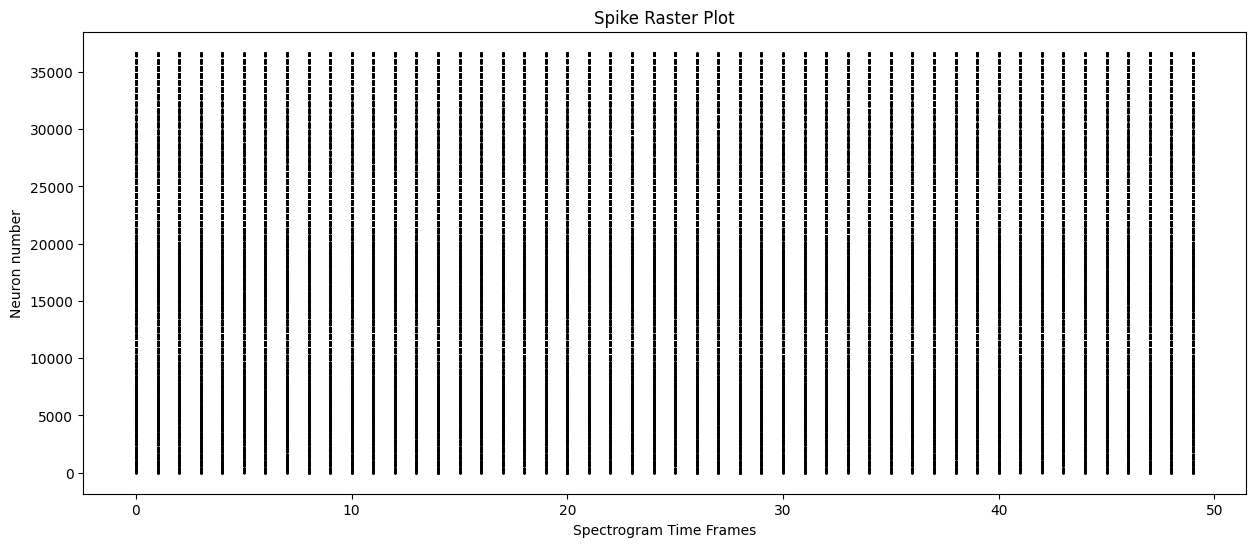

In [33]:
spike_sample = rate_spike_train[:, 0, :, :].reshape((simulation_steps, -1))
print(spike_sample.reshape((simulation_steps, -1)).shape)
#spike_raster = torch.sum(spike_sample, dim=1).reshape((simulation_steps, -1))  # shape: (50, 616)

fig, ax = plt.subplots(figsize=(15, 6))
splt.raster(spike_sample, ax, s=0.5, c="black")
ax.set_xlabel("Spectrogram Time Frames")
ax.set_ylabel("Neuron number")
ax.set_title("Spike Raster Plot")
plt.show()

The number of neurons is decided based on this multiplication:

n_mels * time_bins $\rightarrow 64 * 616 = 39424$  

Now we visualize how a single neuron out of 39424 behaves

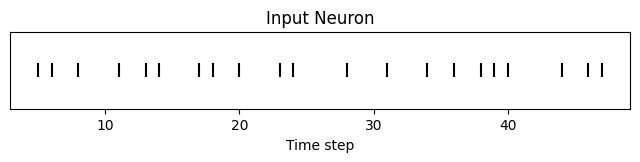

In [34]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_sample.reshape((simulation_steps, -1))[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

## Delta Modulation

Delta modulation converts time-series tensors into spike trains by looking at the difference between pair of subsequent values. By default, if the difference is both *positive* and *greater than a predefined threshold* $V_{\text{thr}}$, a spike is generated. However, this type of encoding does not account for large negative peaks in the signal, leading to a possible loss of information in the encoding. For this reason, we consider also negative spikes (or *off-spikes*), that are generated when the difference between subsequent values is both *negative* and *greater than the threshold* $V_{\text{thr}}$ *in absolute value*.

Mathematically, given an input sequence $x[t], t=1,\dots,T$, where $T$ denotes the number of time steps, and a *positive* threshold $V_{\text{thr}}$, the spike encoding with delta modulation is obtained as:
$$
S[t] =
\begin{cases}
\, 1 \qquad \text{if}\;\; x[t+1]-x[t] > V_{\text{thr}}\\
-1 \;\,\quad \text{if}\;\; x[t+1]-x[t] < -V_{\text{thr}}\\
\, 0 \qquad \text{otherwise.}
\end{cases}
$$

In [222]:
class DeltaModulation:

  def __init__(self, threshold=0.1, off_spike=True):
    self.threshold = threshold
    self.off_spike = off_spike

  def __call__(self, data):
    """
      Args:
        data: list of tensors, one of shape (time_frames, n_mels, channels) for
              spectogram data.

      Returns:
        spikes: List of tensors of shape (time_frames, n_mels, channels)
                Contains 1 for positive spikes, -1 for negative spikes, and 0 otherwise
    """

    data_spikes = []

    for sample in data:
      audio_tensor = sample[0].clone().detach().float() # input for spikegen.delta
      audio_tensor = audio_tensor.permute(1,0,2)
      spikes = spikegen.delta(
          audio_tensor,
          threshold=self.threshold,
          off_spike=self.off_spike
      )

      data_spikes.append(spikes)

    spike_trains = torch.stack([spike for spike in data_spikes])
    labels = torch.stack([sample[1] for sample in data])

    return  [spike_trains, labels]

In [230]:
delta_modulation = DeltaModulation(threshold=0.05)
delta_train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=delta_modulation)
encoded_delta_spike_batch0 = next(iter(delta_train_dataloader))

print(encoded_delta_spike_batch0[0].shape)

torch.Size([32, 616, 64, 1])


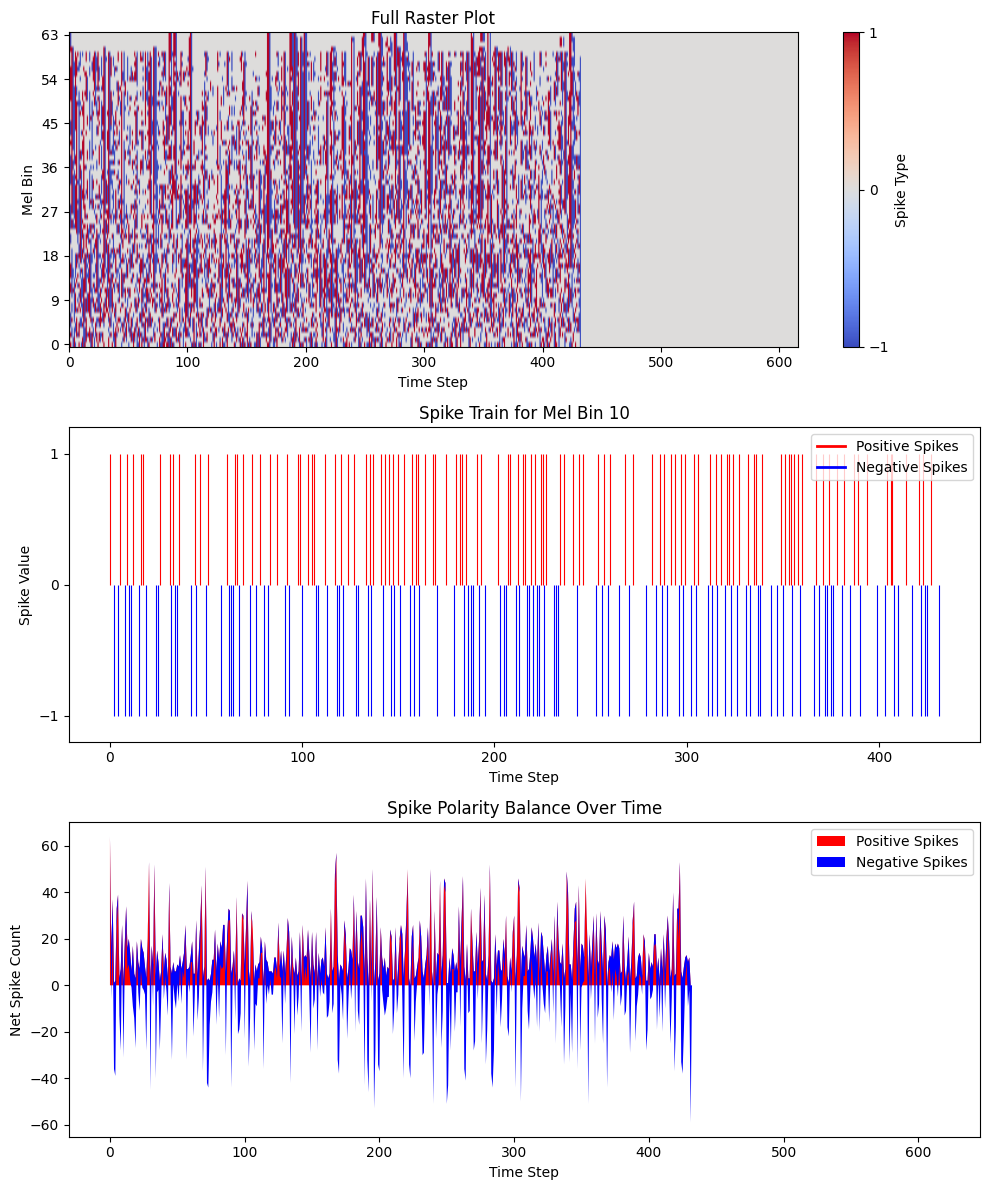

Class crackling_fire


In [236]:
def visualize_delta_spikes(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels, channel]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0][sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels, channel]
        if len(spike_tensor.shape) == 4:
            spikes = spike_tensor[sample_idx, :, :, 0].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")

    # Adjust y-ticks based on actual dimensions
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)  # Create at most 7 ticks
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()


sample_idx = 4
visualize_delta_spikes(encoded_delta_spike_batch0, sample_idx=sample_idx, mel_bin=10)
print("Class", ESCLabels(encoded_delta_spike_batch0[1][sample_idx].item()).name)

## Threshold Adaptive Encoding

Unlike **rate encoding**, where the value directly determines spike probability, Threshold Adaptive Encoding works by:

Setting a dynamic threshold for each input feature
Generating spikes when the input signal crosses this threshold
Adapting the threshold after each spike according to the local signal properties

This encoding method is biologically inspired, as it better mimics how neurons in the brain respond to varying stimulus intensities.


In [38]:
class ThresholdAdaptiveEncoding:

  def __init__(self, threshold=0.1, alpha=1.05):
      """
      Initialize the Threshold-Adaptive Encoding method.

      Args:
          threshold (float): Initial threshold value
          alpha (float): Threshold adaptation factor
                           > 1 for increase after spike
                           < 1 for decrease when no spike
      """
      self.threshold = threshold
      self.alpha = alpha

  def encode(self, data):
    """
      Encode input data using the Threshold-Adaptive Encoding method.

      Args:
        data: Input tensor of shape (batch_size, n_mels, time_frames, channels)
                 For spectrograms, typically channels=1

      Returns:
        spikes: Tensor of shape (time_frames, batch_size, n_mels, channels)
                   Contains 1 for positive spikes, -1 for negative spikes, and 0 otherwise
    """
    # Get input dimensions
    batch_size, n_mels, time_frames, channels = data.shape

    # Initialize output spikes tensor
    # We'll change to time-first representation for SNN compatibility
    spikes = torch.zeros(time_frames, batch_size, n_mels, channels)

    # Process each item in the batch
    for b in range(batch_size):
      for m in range(n_mels):
        for c in range(channels):

          # Initialize base and current threshold for this time series
          base = data[b, m, 0, c].item()
          curr_threshold = self.threshold

          # Process each time step
          for t in range(1, time_frames):
            current_value = data[b, m, t, c].item()


            if current_value >= base + curr_threshold:
              spikes[t, b, m, c] = 1
              base = base + curr_threshold
              curr_threshold = curr_threshold * self.alpha

            elif current_value <= base - curr_threshold:
              spikes[t, b, m, c] = -1
              base = base - curr_threshold
              curr_threshold = curr_threshold * self.alpha
            else:
              curr_threshold = curr_threshold / self.alpha

        return spikes


## Moving Window

## Step Forward